In [35]:
#import libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import json
import ee
%matplotlib inline
import seaborn as sns
from ipygee import*
from shapely.geometry import Polygon

# Trigger the authentication flow.
# ee.Authenticate()
    
# Initialize the GEE
ee.Initialize()

print("Initialized")

Initialized


(1, 3)
  GID_0   COUNTRY                                           geometry
0   ETH  Ethiopia  POLYGON ((38.43719 3.60126, 38.42982 3.60086, ...


<function matplotlib.pyplot.show(close=None, block=None)>

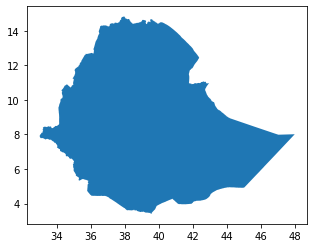

In [36]:
# Define geograpic domain
# read the shapefile of the study area
Ethiopia = gpd.read_file('/Users/valentinaguedesantonaccio/Library/CloudStorage/OneDrive-Nexus365/I.FoD/II.Research/VIII.Labour_Ethiopia/Precipitation/gadm41_ETH_shp/gadm41_ETH_0.shp')
print(Ethiopia.shape)
print(Ethiopia.head())
Ethiopia.plot() #create the plot
plt.show #show the plot

In [37]:
# converting from shapefile to json (aoi = area of interest)
aoi = Ethiopia.to_json()
# load json file
aoi = json.loads(aoi)
# select features
aoi = aoi['features']

aoi = ee.FeatureCollection(aoi).geometry()

In [38]:
startyear1 = 2022
endyear1 = 2023 #(<2023)

# Set date in ee date format
startdate1 = ee.Date.fromYMD(startyear1,1,1)
enddate1 = ee.Date.fromYMD(endyear1,7,31)

# Make a list for years
years1 = range(startyear1, endyear1);

# Make a list for months
months = range(1,8)


In [39]:
# import the RS products
CHIRPS = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')\
                            .select('precipitation')\
                            .filterDate(startdate1,enddate1)\
                            .filterBounds(aoi)

In [31]:
# Statistics function

def reduce (image):
  serie_reduce = image.reduceRegions(**{
      'collection': aoi,
      'reducer': ee.Reducer.mean().combine(**{
      'reducer2': ee.Reducer.max(),
      'sharedInputs': True}).combine(**{
        'reducer2': ee.Reducer.min(),
        'sharedInputs': True}),
      'scale': 1000
      })
  
  serie_reduce = serie_reduce.map(lambda f: f.set({'millis': image.get('millis')}))\
                             .map(lambda f: f.set({'date': image.get('date')}))\
                             .map(lambda f: f.set({'month': image.get('month')}))\
                             .map(lambda f: f.set({'year': image.get('year')}))
  return serie_reduce.copyProperties(image, ['system:time_start'])

precipitation_reduce = monthlyCHIRPS.map(reduce)\
                                    .flatten()\
                                    .sort('date', True)\
                                    .select(['millis', 'date', 'max', 'mean', 'min', 'month', 'year'])

print("Size:",precipitation_reduce.size().getInfo())

Size: 7


In [32]:
# creating the data list
prec_list = precipitation_reduce.reduceColumns(ee.Reducer.toList(5), ['max', 'mean', 'min', 'month', 'year']).values().get(0)
print("Precipitation reduce columns:",prec_list.getInfo())

Precipitation reduce columns: [[140.58014583587646, 15.18103264899499, 0, 1, 2022], [84.18343448638916, 10.755307830036058, 2.3093574275101503e-10, 2, 2022], [162.00280475616455, 26.50951474023567, 0.04828654043376446, 3, 2022], [295.9675874710083, 75.30464568314545, 1.4421551441773772, 4, 2022], [370.2298831939697, 62.130236690294126, 0.4537441781722009, 5, 2022], [456.48368072509766, 87.7805068906802, 0.36340271681547165, 6, 2022], [624.4698753356934, 123.16203964741197, 0.05056474171578884, 7, 2022]]


In [34]:
# creating the dataframe

df_prec = pd.DataFrame(prec_list.getInfo(), columns=['max_prec', 'mean_prec', 'min_prec', 'month', 'year'])

df_prec

# export to .csv
prec_csv1 = df_prec.to_csv('/Users/valentinaguedesantonaccio/Library/CloudStorage/OneDrive-Nexus365/I.FoD/II.Research/VIII.Labour_Ethiopia/Precipitation/CSV/precipitation2.csv')